In [1]:
import pickle
import numpy as np

with open('results/auto_embeddings.pkl', 'rb') as inobj:
    embeddings = pickle.load(inobj)

embeddings_dict = {t[0]:t[1] for t in embeddings }

In [2]:
# Each node in the AIFB dataset is either a person, a project, a publication, a group, etc.
# Here we get a list of all of the nodes that have a certain label and put them in a dictionary
import re
from future.utils import iteritems

publications = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Publikationen\/viewPublikationOWL\/id[0-9]*instance)>")
authors = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Personen\/viewPersonOWL\/id[0-9]*instance)>")
groups = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Forschungsgruppen\/viewForschungsgruppeOWL\/id[0-9]*instance)>")
projects = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Projekte\/viewProjektOWL\/id[0-9]*instance)>")
subjects = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Forschungsgebiete\/viewForschungsgebietOWL\/id[0-9]*instance)>")
organizations = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Kooperationen\/viewOrganizationOWL\/id[0-9]*instance)>")

regex_dict = {"publications":publications, "authors":authors, 
              "groups":groups, "projects": projects, "subjects": subjects,
              "organizations":organizations}

from collections import defaultdict
categories = defaultdict(set)

with open("data/aifb_stripped.nt") as f:
    for line in f:
        for k,reg in iteritems(regex_dict):
            finds = reg.match(line)
            if finds != None:
                categories[k].add(finds.group(1))

for k,v in iteritems(categories):
    print(k,len(v))

('organizations', 28)
('subjects', 146)
('publications', 1232)
('groups', 5)
('authors', 237)
('projects', 78)


In [3]:
import random
#choose a random 100 instances from each category
subset_of_categories = defaultdict(list)

for k,v in iteritems(categories):
    samples = random.sample(v, min(len(v), 100))
    for s in samples:
        subset_of_categories[k].append(s)

for k,v in iteritems(subset_of_categories):
    print(k,len(v))

('organizations', 28)
('subjects', 100)
('publications', 100)
('groups', 5)
('authors', 100)
('projects', 78)


In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import gensim

def scatterplot2D(x_coords, y_coords, vector_labels):
    #Associate a color to each unique label  
    label_dict = {j:i for (i,j) in enumerate(set(vector_labels))}
    cmap = plt.cm.rainbow
    norm = mcolors.Normalize(vmin=0, vmax=len(label_dict))
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords, alpha=0.85, c=[cmap(norm(label_dict[i])) for i in vector_labels])
    #draw the legend
    patches = []
    for k,v in iteritems(label_dict):
        patches.append(mpatches.Patch(color=cmap(norm(v)), label=k))
    plt.legend(handles=patches)
    #draw the scatter plot with some padding
    x_pad = (x_coords.max()-x_coords.min())*.02
    y_pad = (y_coords.max()-y_coords.min())*.02
    plt.xlim(x_coords.min()-x_pad, x_coords.max()+x_pad)
    plt.ylim(y_coords.min()-y_pad, y_coords.max()+y_pad)
    plt.show()

from sklearn.manifold import TSNE
def tsne2D(vectors):
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(vectors)
    return Y

import umap
def umap2D(vectors):
    # find umap coords for 2 dimensions
    umapper = umap.UMAP()
    np.set_printoptions(suppress=True)
    Y = umapper.fit_transform(vectors)
    return Y
 
from sklearn.decomposition import PCA
def pca2D(vectors):
    # find PCA coords for 2 dimensions
    pca = PCA(n_components=2)
    np.set_printoptions(suppress=True)
    Y = pca.fit_transform(vectors)
    return Y

In [5]:
# plot the embeddings in 2D by category
def get_category_embeddings(category_dict, embeddings_dict):
    category_embeddings = []
    category_labels = []
    for k,v in iteritems(category_dict):
        for s in v:
            category_embeddings.append(embeddings_dict[s])
            category_labels.append(k)
    return (category_embeddings, category_labels)

In [6]:
category_embeddings, category_labels = get_category_embeddings(subset_of_categories, embeddings_dict)
y = tsne2D(category_embeddings)
#y = umap2D(category_embeddings)

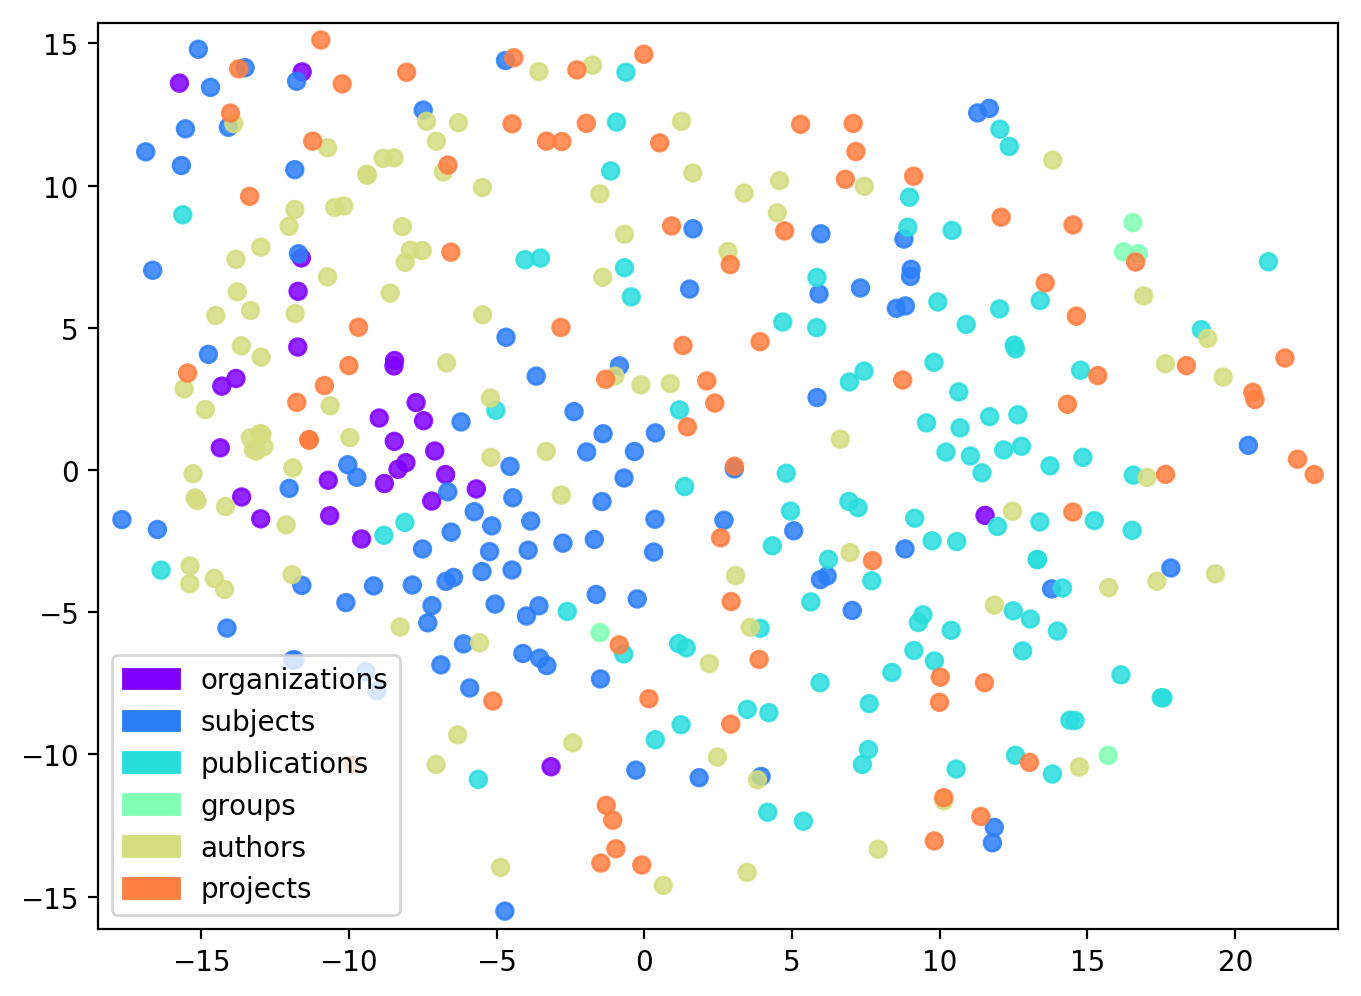

In [7]:
scatterplot2D(y[:,0],y[:,1], category_labels)

In [8]:
import unicodecsv as csv

def get_class_dictionary(filename, skip_first_line=False):
    category_dict = defaultdict(list)
    with open(filename, 'r') as csvfile:
        graphreader = csv.reader(csvfile)
        i = 0
        for row in graphreader:
            if skip_first_line and i == 0:
                i += 1
                continue
            category_dict[row[1]].append(row[0])

    print("Number of instances in each label:")
    for k,v in iteritems(category_dict):
        print(k,len(v))
    return category_dict

In [9]:
# The AIFB dataset has 176 people and they are associated with one of four affiliations in the organization.
# The completeSet.tsv file gives the URIs of the people and their affiliation
# (number, person, affiliation)
people_organization_dict = get_class_dictionary('data/completeDataset.csv', True)
people_embeddings, people_labels = get_category_embeddings(people_organization_dict, embeddings_dict)
people_y = tsne2D(people_embeddings)
#people_y = umap2D(people_embeddings)

Number of instances in each label:
(u'http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id4instance', 15)
(u'http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id1instance', 73)
(u'http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id2instance', 28)
(u'http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id3instance', 60)


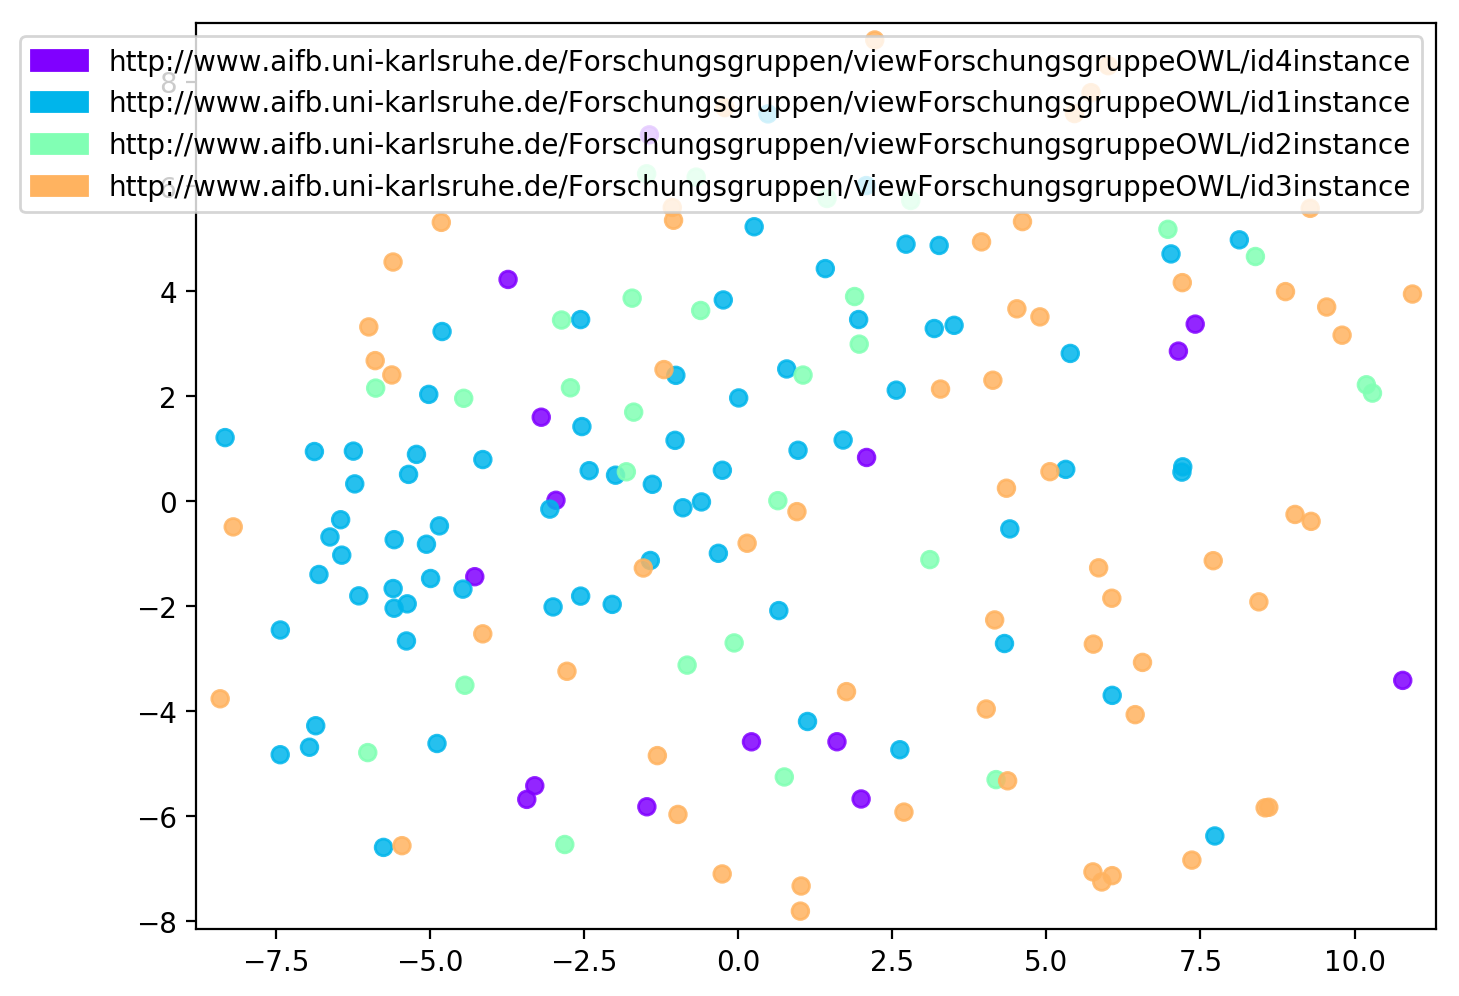

In [10]:
scatterplot2D(people_y[:,0],people_y[:,1], people_labels)

In [ ]:
# use clustering to do unsupervised learning on the selected embeddings
from sklearn.cluster import KMeans, SpectralClustering

def cluster_model(embeded_vectors, labels):
    cluster_model = SpectralClustering(n_clusters=len(set(labels)))
    all_predictions = cluster_model.fit_predict(embeded_vectors)
    return (all_predictions)

In [ ]:
#using the predicted labels for the vectors
predicted_people_labels = cluster_model(people_embeddings, people_labels)
scatterplot2D(people_y[:,0],people_y[:,1], predicted_people_labels)

In [ ]:
#Embeddings of the projects associated with an affiliations
projects_dict = get_class_dictionary('data/project_carried_out.csv', True)
projects_embeddings, projects_labels = get_category_embeddings(projects_dict, embeddings_dict)
#projects_y = tsne2D(projects_embeddings)
projects_y = umap2D(projects_embeddings)
predicted_projects_labels = cluster_model(projects_embeddings, projects_labels)

In [ ]:
scatterplot2D(projects_y[:,0],projects_y[:,1], projects_labels)
scatterplot2D(projects_y[:,0],projects_y[:,1], predicted_projects_labels)

In [ ]:
#Embeddings of the projects and who they were financed by
financed_dict = get_class_dictionary('data/projects_financed.csv', True)
# Only use the financial sources that financed more than 3 project
financed_dict = {k: v for k, v in iteritems(financed_dict) if len(v) > 3}
print("Number of instances in each label:")
for k,v in iteritems(financed_dict):
    print(k,len(v))

In [ ]:
financed_embeddings, financed_labels = get_category_embeddings(financed_dict, embeddings_dict)
#financed_y = tsne2D(financed_embeddings)
financed_y = umap2D(financed_embeddings)
predicted_financed_labels = cluster_model(financed_embeddings, financed_labels)

In [ ]:
scatterplot2D(financed_y[:,0],financed_y[:,1], financed_labels)
scatterplot2D(financed_y[:,0],financed_y[:,1], predicted_financed_labels)